# 第12章 ニューラルネットワーク - 画像認識トレーニング

- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
- ディープラーニング(deep learning)
- 人工ニューラルネットワーク(artificial neural network)

- 多層ニューラルネットワークの概念を理解する
- 画像を分類するためのニューラルネットワークをトレーニングする
- ニューラルネットワークをトレーニグするための強力なバッグプロパゲーションアルゴリズムを実装する
- ニューラルネットワークの実装をデバッグする

## 12.1 人工ニューラルネットワークによる複雑な関数のモデリング

- McCullochPittニューロンモデル
- バックプロパゲーション(backpropagation)アルゴリズム
- 特徴抽出器(feature detector)

### 12.1.1 単層ニューラルネットワークのまとめ

- ADALINE(ADAptive LInear NEuron)
- 勾配降下法
- エポック(データセットのトレーニング回数)
- 誤差平方和(SSE)
- コスト関数 J(w)
- 学習率η
- ニューロンの活性(activation)
- しきい値関数(ヘビサイド関数)

### 12.1.2 多層ニューラルネットワークアーキテクチャ

- 多層フィードフォワードニューラルネットワーク(multi-layer feedforward neural network)
- 多層パーセプトロン(Multi-Layer Parceptron: MLP)
- 隠れ層(hidden layer)

### 12.1.3 フォワードプロパゲーションによるニューラルネットワークの活性化

- フォワードプロパゲーション(順伝搬法、forward propagation)

1. 入力層を出発点として、トレーニングデータのパターンをネットワーク経由で順方向に伝搬させ、出力を生成する。
2. ネットワークの出力に基づき、後ほど説明するコスト関数を使って誤差を計算する。この誤差を最小化することが目的となる。
3. 誤差を逆方向に伝搬させることで、ネットワーク内の各重みに対する偏導関数を求め、モデルを更新する。

## 12.2 手書きの数字を分類する

- MNIST(Mixed National Istitute of Standards and Technology)データセット

### 12.2.1 MNISTデータセットを取得する

- http://yann.lecun.com/exdb/mnist/

In [17]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """
    MNISTデータをpathからロード
    """
    # 引数に指定したパスを結合(ラベルや画像のパスを作成)
    labels_path = os.path.join(path, '{}-labels-idx1-ubyte'.format(kind))
    images_path = os.path.join(path, '{}-images-idx3-ubyte'.format(kind))
    
    # ファイルを読み込む
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換: npack関数の引数にフォーマット、8バイト分の
        # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築: fromfile関数の引数に
        # ファイル、配列のデータ形式を指定
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更
        # (行数: ラベルのサイズ、列数: 特徴量の個数
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

images

- トレーニングデータセット: 60,000個
- テストデータセット: 10,000個
- 28x28 ピクセルの画像(784ピクセル)
- 各ピクセルはグレースケールの輝度(明暗)

labels

- 目的変数は手書き数字のクラスラベル(0〜9の整数)

In [20]:
X_train, y_train = load_mnist('chapter12', kind='train')
print('Rows: {:d}, columns: {}'.format(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('chapter12', kind='t10k')
print('Rows: {:d}, columns: {}'.format(X_test.shape[0], X_test.shape[1]))


Rows: 60000, columns: 784
Rows: 10000, columns: 784


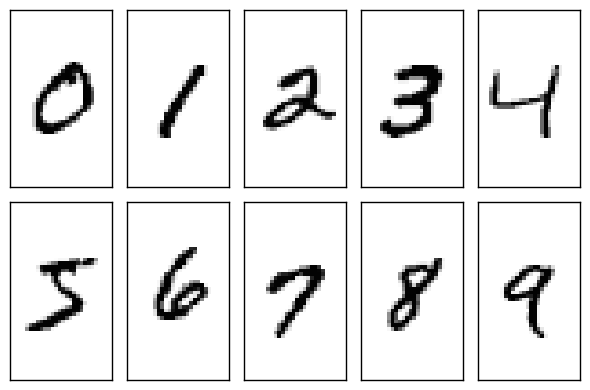

In [28]:
# 0〜9の数字の例を可視化する

import matplotlib.pyplot as plt
# subplots で描画の設定: 引数で描画領域の行数 / 列数、x/y 実の統一を指定
flg, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
# 配列を1次元に変換
ax = ax.flatten()
for i in range(10):
    # 配列を 28x28 に変形
    img = X_train[y_train == i][0].reshape(28, 28)
    # 色や補完方法を指定
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

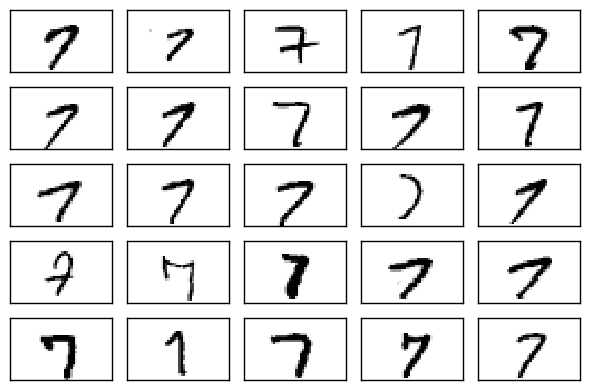

In [23]:
# 数字7のサンプルを25個ヒョ持する

import matplotlib.pyplot as plt
flg, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
# 配列を1次元に変換
ax = ax.flatten()
for i in range(len(ax)):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [29]:
# MNISTの画像データをCSVファイルとして保存する
if False:
    np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
    np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
    np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
    np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')

# MNISTの画像データをCSVファイルから読み込む
if False:
    X_train = np.genfromtxt('train_img.csv', fmt='%i', delimiter=',')
    y_train = np.savetxt('train_labels.csv', fmt='%i', delimiter=',')
    X_test = np.savetxt('test_img.csv', fmt='%i', delimiter=',')
    y_test = np.savetxt('test_labels.csv', fmt='%i', delimiter=',')

### 12.2.2 多層パーセプトロンを実装する

In [45]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        """
        NeruralNetMLPの初期化
        """
        np.random.seed(random_state)
        self.n_output = n_output # 出力ユニット数
        self.n_features = n_features # 入力ユニット数
        self.n_hidden = n_hidden # 隠れユニット数
        self.w1, self.w2 = self._initialize_weights() # 重みの初期化
        self.l1 = l1 # L1正則化のλパラメータ
        self.l2 = l2 # L2正則化のλパラメータ
        self.epochs = epochs # エポック数(トレーニング回数)
        self.eta = eta # 学習率の初期値
        self.alpha = alpha # モーメンタム学習の1つ前の勾配の係数
        self.decrease_const = decrease_const # 適応学習率の減少定数
        self.shuffle = shuffle # データのシャッフル
        self.minibatches = minibatches # 各エポックでのミニバッチ数
        
    def _encode_labels(self, y, k):
        """
        ラベルのエンコード
        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        """
        重みの初期化
        """
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output * (self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
                
        return w1, w2
    
    def _sigmoid(self, z):
        """
        シグモイド関数
        """
        # expit は 1.0 / (1.0 + np.exp(-z)) に等しい
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        """
        シグモイド関数の勾配(編微分係数)
        """
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        """
        バイアスユニットの追加
        """
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        
        return X_new
    
    def _feedforward(self, X, w1, w2):
        """
        フィードフォワード
        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        """
        L2 ペナルティ項の係数
        """
        return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """
        L1 ペナルティ項の係数
        """
        return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        """
        ロジスティック関数
        """
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # バックプロパゲーション
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        # 正則化
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2

    def predict(self, X):
        """
        フィードフォワードによる予測
        """
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        """
        モデルをデータに適合させる
        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            # 適応学習率
            self.eta /= (1 + self.decrease_const * i)
            if print_progress:
                sys.stderr.write('\rEpoch: {}/{}'.format(i + 1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # フィードフォワード
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # バックプロパゲーションによる勾配の計算
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                # 重みの更新
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self

* l2/l2: 過学習の度合いを減らすための、L2/L1正則化のλパラメータ
* epochs: トレーニングデータセットをトレーニングする回数
* eta: 学習率の初期化
* alpha: モーメンタム学習のパラメータ。モーメンタム学習により、1つ前の勾配の係数を重みの更新に促すことで、学習を加速させる
* decrease_const: 徐々に減少する適応学習率の減少定数d
* shuffle: 各エポックの前にトレーニングデータセットをシャッフルすることで、アルゴリズムが循環しないようにする
* minibatches: 各エポックでトレーニングデータをk個のミニバッチに分割する。学習を加速させるために、トレーニングデータ全体ではなくミニバッチごとに勾配が計算される

In [46]:
# 784個の入力ユニット
# 50個の隠れユニット
# 10個の出力ユニット
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [47]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

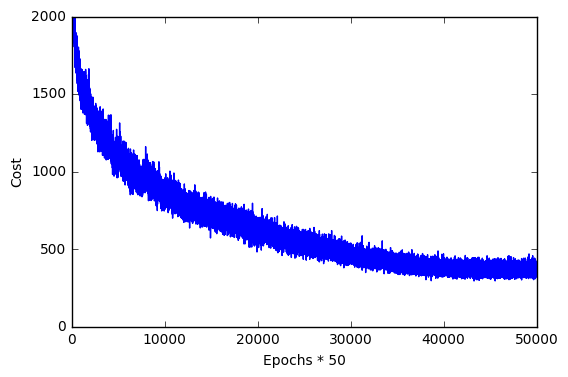

In [48]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.show()

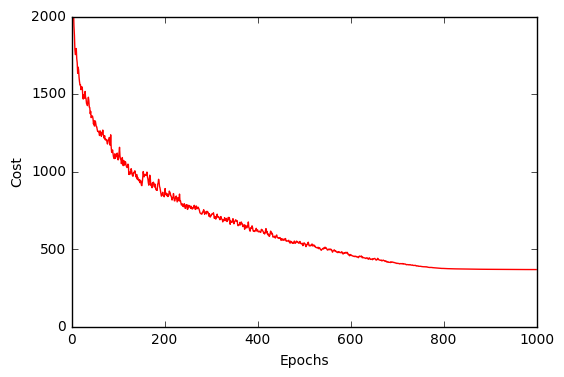

In [53]:
# ミニバッチのインターバルを平均化することで、エポックの回数に対してより滑かなコスト関数をプロットする
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [56]:
# 正解率を計算する
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: {:.2f}%'.format(acc * 100))

y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: {:.2f}%'.format(acc * 100))

Training accuracy: 97.59%
Test accuracy: 95.66%


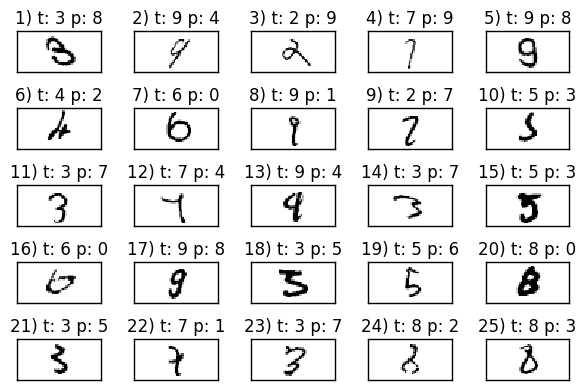

In [60]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]
flg, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(len(ax)):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('{}) t: {} p: {}'.format(i + 1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()